In [210]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.svm import SVC
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [211]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**DATA EXPLORATION :**

In [212]:
df = pd.read_csv('/content/Flipkart_Amazon Mobile Reviews.csv')

In [213]:
df.head(2)

,Unnamed: 0,Review-Title,rating,Review-Body,Product Name
0,0,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
1,1,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."


In [214]:
df.shape

(23777, 5)

In [215]:
df.describe()

,Unnamed: 0
count,23777.000000
mean,11888.000000
std,6863.973011
min,0.000000
25%,5944.000000
50%,11888.000000
75%,17832.000000
max,23776.000000


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23777 entries, 0 to 23776
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    23777 non-null  int64 
 1   Review-Title  23775 non-null  object
 2   rating        23777 non-null  object
 3   Review-Body   23160 non-null  object
 4   Product Name  23777 non-null  object
dtypes: int64(1), object(4)
memory usage: 928.9+ KB


In [217]:
df.isnull().sum()

Unnamed: 0        0
Review-Title      2
rating            0
Review-Body     617
Product Name      0
dtype: int64

**DATA CLEANING :**

In [218]:
df.dropna(subset = ['Review-Body'], inplace = True)

In [219]:
df.isnull().sum()

Unnamed: 0      0
Review-Title    1
rating          0
Review-Body     0
Product Name    0
dtype: int64

In [220]:
ratings = df['rating'].apply(lambda x: float(re.findall(r'\d+\.\d+', x)[0]) if re.findall(r'\d+\.\d+', x) else np.nan)


In [221]:
df['rating'] = df['rating'].str.extract(r'(\d+\.\d+)').astype(float)

In [222]:
df['rating'].head(2)

0    1.0
1    2.0
Name: rating, dtype: float64

**DATA VISUALIZATION :**

In [223]:
# Calculate average ratings for each category
category_ratings = df.groupby('Product Name')['rating'].mean()

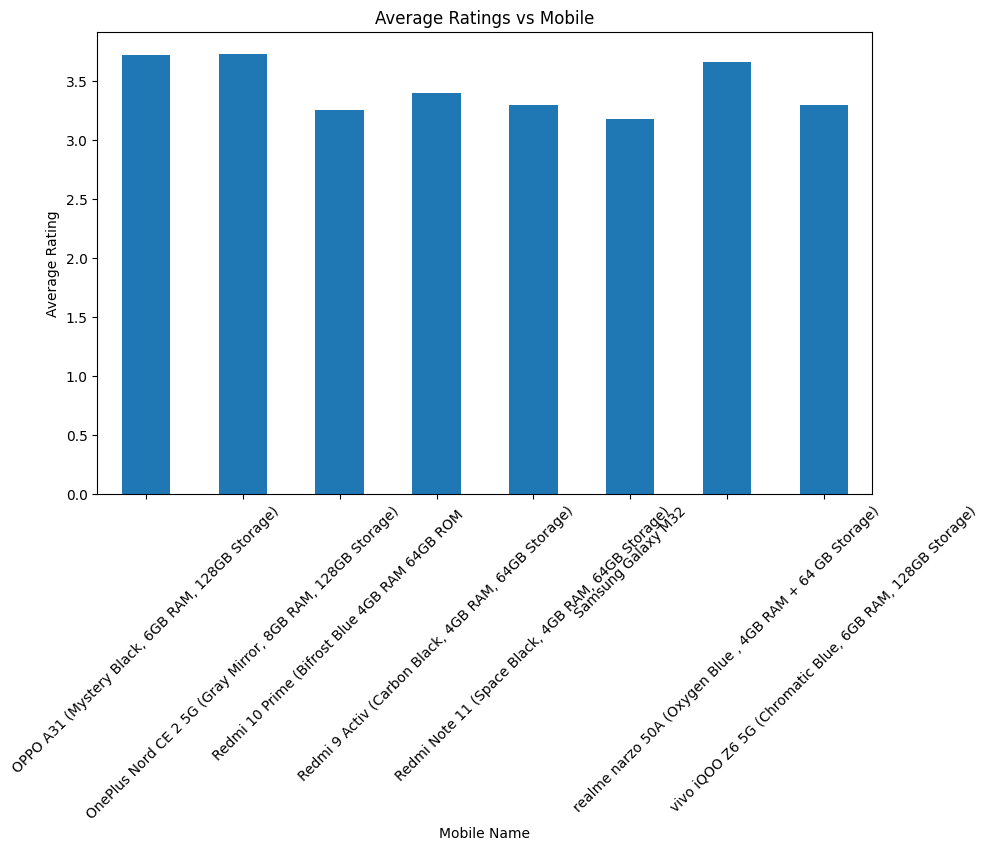

In [224]:
# Bar plot
plt.figure(figsize=(10, 6))
category_ratings.plot(kind='bar')
plt.xlabel('Mobile Name')
plt.ylabel('Average Rating')
plt.title('Average Ratings vs Mobile')
plt.xticks(rotation=45)
plt.show()

In [225]:
df.head(2)

,Unnamed: 0,Review-Title,rating,Review-Body,Product Name
0,0,Worst phone ever,1.0,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
1,1,Ok !!! Not up to the mark,2.0,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."


In [226]:
# Handle missing values
df['Review-Body'].fillna('', inplace=True)
df['Review-Title'].fillna('', inplace=True)

In [227]:
# Combine review title and body
df['Review'] = df['Review-Title'] + ' ' + df['Review-Body']

In [228]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

**TEXT PREPROCESSING :**

In [229]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [230]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    # Join tokens back to form the preprocessed text
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

In [231]:
df['Preprocessed Review'] = df['Review'].apply(preprocess_text)

In [232]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(df['Preprocessed Review'])

**MODEL BUILDING :**

In [233]:
# Train test split
X_train, X_test, train_ratings, test_ratings = train_test_split(X, ratings, test_size=0.2, random_state=42)

In [234]:
model = SVC(kernel='linear')
model.fit(X_train, train_ratings)

SVC(kernel='linear')

**MODEL TESTING :**

In [235]:
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(test_ratings, y_pred)
precision = metrics.precision_score(test_ratings, y_pred, average='weighted')
recall = metrics.recall_score(test_ratings, y_pred, average='weighted')
f1_score = metrics.f1_score(test_ratings, y_pred, average='weighted')

In [236]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.6006044905008635
Precision: 0.5453409378734627
Recall: 0.6006044905008635
F1 Score: 0.543651598557162


In [237]:
# Percentage of Positive and Negative Reviews
positive_reviews = np.sum(y_pred >= 3.0)  # Assuming ratings greater than or equal to 3 are positive
negative_reviews = np.sum(y_pred < 3.0)  # Assuming ratings less than 3 are negative
total_reviews = len(y_pred)

In [238]:
positive_percentage = (positive_reviews / total_reviews) * 100
negative_percentage = (negative_reviews / total_reviews) * 100

In [239]:
print(f"Positive Reviews Percentage: {positive_percentage}%")
print(f"Negative Reviews Percentage: {negative_percentage}%")

Positive Reviews Percentage: 70.89810017271158%
Negative Reviews Percentage: 29.10189982728843%


In [240]:
category_ratings = {'camera': 0, 'battery': 0, 'display': 0, 'value for money': 0, 'performance': 0}

In [241]:
for category in category_ratings.keys():
    category_reviews = test[test['Product Name'] == category]
    category_pred = y_pred[test['Product Name'] == category]

    positive_reviews = np.sum(category_pred >= 3.0)
    negative_reviews = np.sum(category_pred < 3.0)
    total_reviews = len(category_pred)

    if total_reviews != 0:
        category_ratings[category] = (5 * positive_reviews + 1 * negative_reviews) / total_reviews
    else:
        category_ratings[category] = 0

In [242]:
print("Category Ratings:")
for category, rating in category_ratings.items():
    print(f"{category}: {rating}")

Category Ratings:
camera: 0
battery: 0
display: 0
value for money: 0
performance: 0


**RANKING TABLE**

In [243]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [244]:
def extract_sentiment(review):
    doc = nlp(review)
    sentiment_score = doc.sentiment.polarity
    return sentiment_score

In [245]:
from textblob import TextBlob
df['Sentiment'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
overall_rankings = df.groupby('Product Name')['Sentiment'].mean().sort_values(ascending=False)

In [246]:
print("Ranking Table:")
print(overall_rankings)

Ranking Table:
Product Name
OPPO A31 (Mystery Black, 6GB RAM, 128GB Storage)              0.341881
OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 128GB Storage)    0.314333
realme narzo 50A (Oxygen Blue , 4GB RAM + 64 GB Storage)      0.311180
Redmi 9 Activ (Carbon Black, 4GB RAM, 64GB Storage)           0.249577
vivo iQOO Z6 5G (Chromatic Blue, 6GB RAM, 128GB Storage)      0.220684
Redmi Note 11 (Space Black, 4GB RAM, 64GB Storage)            0.197559
Samsung Galaxy M32                                            0.194897
Redmi 10 Prime (Bifrost Blue 4GB RAM 64GB ROM                 0.182282
Name: Sentiment, dtype: float64
